# Aspect-Based Sentiment Analysis (ABSA) for App Store Reviews

**Project Goal:** Build an automated pipeline using LLMs to extract aspects from app reviews and determine sentiment for each aspect individually.

## Phase 1: Setup, Data Collection, & Prompt Engineering

This notebook will guide you through:
1. Environment setup and data collection
2. Prompt engineering for aspect extraction
3. Sentiment classification per aspect
4. Building a scalable pipeline

## Step 1: Environment Setup and Imports

First, let's import all necessary libraries and verify the environment is correctly configured.

In [1]:
!pip install google-play-scraper
!pip install google-generativeai --upgrade

!pip install requests urllib3 --upgrade

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.7/64.7 kB 2.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 131.1/131.1 kB 6.0 MB/s eta 0:00:00
  Attempting uninstall: urllib3
    Found existing installation: urllib3 2.5.0
    Uninstalling urllib3-2.5.0:
      Successfully uninstalled urllib3-2.5.0
  Attempting uninstall: requests
    Found existing installation: requests 2.32.4
    Uninstalling requests-2.32.4:
      Successfully uninstalled requests-2.32.4
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires requests==2.32.4, but you have requests 2.32.5 which is incompatible.


In [3]:
# Import standard libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import json
from datetime import datetime
import warnings
import time
import os
# warnings.filterwarnings('ignore')

from google_play_scraper import app, reviews, Sort

import google.generativeai as genai

# Set plotting style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

print("✓ All libraries imported successfully!")
print(f"Pandas version: {pd.__version__}")

✓ All libraries imported successfully!
Pandas version: 2.2.2


## Step 2: Configure Gemini API

Set up your Google Gemini API key. You'll need to get an API key from [Google AI Studio](https://makersuite.google.com/app/apikey).

**Note:** Never commit your API key to version control. Consider using environment variables or a `.env` file.

In [12]:
from google.colab import userdata
import google.generativeai as genai

genai.configure(api_key=userdata.get('GEMINI_API_KEY'))

model = genai.GenerativeModel(
    model_name='gemini-2.5-flash',
    # Optional: specific config to force JSON output later
    generation_config={"response_mime_type": "application/json"}
)

print("✓ Gemini API configured successfully!")
print(f"Model: {model.model_name}")

✓ Gemini API configured successfully!
Model: models/gemini-2.5-flash


## Step 3: Data Collection Functions

We'll create helper functions to scrape reviews from both App Store and Google Play Store.

In [5]:
def scrape_play_store_reviews(app_id, country='us', num_reviews=100):
    """
    Scrape reviews from Google Play Store.
    """
    try:
        print(f"Scraping {num_reviews} reviews from Play Store...")
        result, _ = reviews(
            app_id,
            lang='en',
            country=country,
            sort=Sort.NEWEST,
            count=num_reviews
        )

        reviews_data = []
        for review in result:
            reviews_data.append({
                'review_id': review['reviewId'],  # CRITICAL FIX: Capture unique ID
                'date': review['at'],
                'rating': review['score'],
                'title': None,                    # FIX: Play Store has no titles
                'review': review['content'],
                'user': review['userName'],
                'platform': 'Play Store'
            })

        df = pd.DataFrame(reviews_data)
        print(f"✓ Scraped {len(df)} reviews from Play Store")
        return df

    except Exception as e:
        print(f"Error scraping Play Store: {e}")
        return pd.DataFrame()

Real test with spotify

In [6]:
app_id = 'com.spotify.music'

df = scrape_play_store_reviews(
    app_id=app_id,
    num_reviews=1000
)

# 2. Check the data
print(f"\nShape of dataset: {df.shape}")
print(df.head())

# 3. Save the raw data (Milestone 1 Achieved)
if not df.empty:
    filename = 'raw_reviews.csv'
    df.to_csv(filename, index=False)
    print(f"\n✓ Success! Saved {len(df)} reviews to '{filename}'")
else:
    print("\n❌ Warning: No data was scraped.")

Scraping 1000 reviews from Play Store...
✓ Scraped 1000 reviews from Play Store

Shape of dataset: (1000, 7)
                              review_id                date  rating title  \
0  9b988677-20c9-444e-9962-c5e6fd243f55 2025-12-06 04:34:56       5  None   
1  86036146-be78-4e69-9e77-1d395281b877 2025-12-06 04:33:58       4  None   
2  d692421f-d0ee-46b0-b822-b3b27044d5bb 2025-12-06 04:31:41       1  None   
3  ce6ba1c2-6a7c-4595-a2d8-027705ab7f5e 2025-12-06 04:30:54       5  None   
4  16a42a93-baab-4b09-8fab-c3afdd1cc26b 2025-12-06 04:29:21       4  None   

                                              review               user  \
0                                               Osum  Rajan Shrivastava   
1  a bit of ads for ones without premium, but hat...   ATASHI BISAI DAS   
2  Despite several people raising the request to ...        coder a v g   
3  Excellent hearing experience, everything under...       Sujit mondal   
4  it's goodd I like it but it's little annoying ... 

Testing aspect extraction on 5 reviews

In [7]:
valid_model_name = 'gemini-2.5-flash'

print(f"Switching to model: {valid_model_name}")

model = genai.GenerativeModel(
    model_name=valid_model_name,
    # This config ensures the model outputs valid JSON for our parsing step
    generation_config={"response_mime_type": "application/json"}
)

print("✓ Model configured!")

Switching to model: gemini-2.5-flash
✓ Model configured!


In [13]:
import json
import time

def extract_aspects(review_text, model):
    """
    Uses Gemini 2.5 Flash to extract aspects from a review in JSON format.
    """
    prompt = f"""
    You are an expert app review analyst.
    Task: Extract the specific features, functionalities, or topics (aspects) mentioned in this app review.

    Guidelines:
    - Group similar concepts into standard terms (e.g., use "UI/Design" for "look", "interface", "colors").
    - Focus on technical and functional aspects like: "Audio Quality", "Pricing", "Premium", "Search", "Playlist", "UI/Design", "Performance", "Ads".
    - Ignore generic praise like "good app" or "wow" unless a specific feature is named.
    - If no specific aspects are mentioned, return an empty list.

    Review: "{review_text}"

    Output format: JSON with a single key "aspects" containing a list of strings.
    Example: {{"aspects": ["Audio Quality", "Pricing"]}}
    """

    try:
        response = model.generate_content(
            prompt,
            generation_config={"response_mime_type": "application/json"}
        )

        # 3. Parse the response
        # text = response.text
        data = json.loads(response.text)
        return data.get("aspects", [])

    except Exception as e:
        print(f"Error processing review: {e}")
        return []

# --- TEST BLOCK ---
print("Testing Aspect Extraction on the first 5 reviews...\n")

# store results temporarily
test_results = []

for i, row in df.head(5).iterrows():
    review = row['review']
    print(f"Review #{i}: {review[:100]}...") # Print first 100 chars

    aspects = extract_aspects(review, model)
    print(f" -> Extracted Aspects: {aspects}\n")

    # Sleep briefly to avoid hitting free tier rate limits
    time.sleep(1)

Testing Aspect Extraction on the first 5 reviews...

Review #0: Osum...
 -> Extracted Aspects: []

Review #1: a bit of ads for ones without premium, but hats off man , this is the best music app till date .....
 -> Extracted Aspects: ['Ads', 'Premium']

Review #2: Despite several people raising the request to add the Kannada category, Spotify has always turned a ...
 -> Extracted Aspects: ['Content Library']

Review #3: Excellent hearing experience, everything under one roof,not only that it feels heart....
 -> Extracted Aspects: ['Audio Quality']

Review #4: it's goodd I like it but it's little annoying because of the ads but it's good....
 -> Extracted Aspects: ['Ads']



Sentiment Analysis

In [14]:
def analyze_sentiment(review_text, aspect, model):
    """
    Determines the sentiment (Positive, Negative, Neutral) for a specific aspect.
    """
    prompt = f"""
    You are an expert sentiment analyst.

    Task: Determine the sentiment expressed about the specific aspect: "{aspect}" in the user review below.

    Rules:
    - Return "Positive", "Negative", or "Neutral".
    - "Neutral" means the aspect is mentioned factually without strong emotion, or the sentiment is mixed/unclear.
    - Base your decision ONLY on what is said about "{aspect}". Ignore sentiment regarding other features.

    Review: "{review_text}"

    Output format: JSON with a single key "sentiment".
    Example: {{"sentiment": "Negative"}}
    """

    try:
        response = model.generate_content(
            prompt,
            generation_config={"response_mime_type": "application/json"}
        )
        data = json.loads(response.text)
        return data.get("sentiment", "Neutral")

    except Exception as e:
        print(f"Error analyzing sentiment: {e}")
        return "Neutral"

# --- TEST THE FULL CHAIN ---
print("Testing Full Pipeline on Review #3 & #4...\n")

# Let's re-use the complex reviews from your previous test
complex_indices = [3, 4]

for i in complex_indices:
    row = df.iloc[i]
    review = row['review']
    print(f"Review #{i}: {review[:100]}...")

    # 1. Extract Aspects
    aspects = extract_aspects(review, model)
    print(f" -> Aspects Found: {aspects}")

    # 2. Analyze Sentiment for EACH aspect
    for aspect in aspects:
        sentiment = analyze_sentiment(review, aspect, model)
        print(f"    -> Sentiment for '{aspect}': {sentiment}")
    print("-" * 50)

    # Sleep to be safe
    time.sleep(1)

Testing Full Pipeline on Review #3 & #4...

Review #3: Excellent hearing experience, everything under one roof,not only that it feels heart....
 -> Aspects Found: ['Audio Quality']


Error analyzing sentiment: 429 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-flash:generateContent?%24alt=json%3Benum-encoding%3Dint: You exceeded your current quota, please check your plan and billing details. For more information on this error, head to: https://ai.google.dev/gemini-api/docs/rate-limits. To monitor your current usage, head to: https://ai.dev/usage?tab=rate-limit. 
* Quota exceeded for metric: generativelanguage.googleapis.com/generate_content_free_tier_requests, limit: 5, model: gemini-2.5-flash
Please retry in 15.205857648s.
    -> Sentiment for 'Audio Quality': Neutral
--------------------------------------------------
Review #4: it's goodd I like it but it's little annoying because of the ads but it's good....
Error processing review: ('Connection aborted.', RemoteDisconnected('Remote end closed connection without response'))
 -> Aspects Found: []
--------------------------------------------------


Generating a set of 100 reviews which I will manually label. I will compare this with the AI generated labels later on to determine accuracy.

In [ ]:
# Select 100 random reviews for the "Ground Truth" set
ground_truth_df = df.sample(n=100, random_state=42) # fixed seed for reproducibility

# Create a clean file for you to annotate
# We include columns for you to fill in
ground_truth_df['human_aspects'] = ''   # You will fill this list e.g., "UI, Pricing"
ground_truth_df['human_sentiments'] = '' # You will fill this list e.g., "Positive, Negative"

ground_truth_df.to_csv('manual_labeling_task.csv', index=False)

print(f"✓ Created 'manual_labeling_task.csv' with {len(ground_truth_df)} reviews.")
print("Download this file later to perform your manual evaluation.")

✓ Created 'manual_labeling_task.csv' with 100 reviews.
Download this file later to perform your manual evaluation.


This code implements a robust Aspect-Based Sentiment Analysis (ABSA) pipeline using Google's Gemini 2.5 Flash model, employing a chained prompting strategy to extract aspects and classify their sentiment. It features a fault-tolerant design with a custom safe_api_call function that handles API rate limits and timeouts through retries and exponential backoff. The script also includes logic to resume processing from an existing output file and saves progress periodically, ensuring efficiency and preventing data loss during large-scale execution.

In [ ]:
import time
import json
import pandas as pd
import os
import google.generativeai as genai
from google.api_core.exceptions import ResourceExhausted, DeadlineExceeded, ServiceUnavailable

# --- CONFIGURATION ---
model = genai.GenerativeModel(
    model_name='gemini-2.5-flash',
    generation_config={"response_mime_type": "application/json"}
)

output_file = 'llm_results_final.csv'
API_DELAY = 8
# ---------------------

def safe_api_call(func, *args, **kwargs):
    max_retries = 5
    wait_time = 60

    # Add a timeout to the arguments so it doesn't hang forever
    kwargs['request_options'] = {'timeout': 30}

    for attempt in range(max_retries):
        try:
            return func(*args, **kwargs)
        except (ResourceExhausted, ServiceUnavailable, DeadlineExceeded) as e:
            # DeadlineExceeded = The timeout we just added
            print(f" [!] Retry ({e.__class__.__name__}). Sleeping {wait_time}s...", end="", flush=True)
            time.sleep(wait_time)
            wait_time += 10
        except Exception as e:
            if "429" in str(e):
                print(f" [!] 429 Error. Sleeping {wait_time}s...", end="", flush=True)
                time.sleep(wait_time)
            else:
                print(f" [x] Error: {e}")
                return None
    return None

def save_batch(data, filename):
    if not data: return
    df_new = pd.DataFrame(data)
    header = not os.path.exists(filename)
    df_new.to_csv(filename, mode='a', header=header, index=False)

# 1. Resume Logic
processed_ids = set()
if os.path.exists(output_file):
    try:
        processed_ids = set(pd.read_csv(output_file, usecols=['review_id'])['review_id'].unique())
        print(f"Resuming... Found {len(processed_ids)} reviews processed.")
    except: pass

remaining_df = df[~df['review_id'].isin(processed_ids)]
print(f"Remaining: {len(remaining_df)}")

# 2. Processing Loop with explicit "Alive" indicators
current_batch = []
save_frequency = 5

if len(remaining_df) > 0:
    try:
        for index, row in remaining_df.iterrows():
            review_id = row['review_id']
            review_text = row['review']

            print(f"Review {index}: Asking Aspect...", end=" ", flush=True)

            # Aspect Extraction
            aspect_prompt = f"""
            Extract distinct technical/functional aspects (e.g. 'UI', 'Pricing', 'Audio', 'Ads') from this app review.
            Group synonyms. Return JSON: {{"aspects": ["..."]}}.
            Review: "{review_text}"
            """

            # This call now has a 30s timeout
            response_obj = safe_api_call(model.generate_content, aspect_prompt)
            time.sleep(API_DELAY)

            aspects = []
            if response_obj:
                try: aspects = json.loads(response_obj.text).get("aspects", [])
                except: pass

            print(f"Got {len(aspects)}. Sentiments...", end=" ", flush=True)

            # Sentiment Analysis
            if not aspects:
                current_batch.append({'review_id': review_id, 'aspect': 'None', 'sentiment': 'None', 'original_text': review_text})
            else:
                for aspect in aspects:
                    sentiment_prompt = f"""
                    Determine sentiment (Positive, Negative, Neutral) for the aspect "{aspect}" in this review.
                    Return JSON: {{"sentiment": "..."}}.
                    Review: "{review_text}"
                    """
                    response_obj = safe_api_call(model.generate_content, sentiment_prompt)
                    time.sleep(API_DELAY)

                    sentiment = "Neutral"
                    if response_obj:
                        try: sentiment = json.loads(response_obj.text).get("sentiment", "Neutral")
                        except: pass

                    current_batch.append({'review_id': review_id, 'aspect': aspect, 'sentiment': sentiment, 'original_text': review_text})
                    print(".", end="", flush=True) # Dot for every sentiment done

            print(" Done.")

            # Save Checkpoint
            if len(current_batch) >= save_frequency:
                save_batch(current_batch, output_file)
                current_batch = []

    except KeyboardInterrupt:
        print("\nStopped by user. Saving remaining data...")
        save_batch(current_batch, output_file)

    except Exception as e:
        print(f"\nUnexpected Error: {e}")
        save_batch(current_batch, output_file)

    else:
        save_batch(current_batch, output_file)
        print("\n✓ Pipeline Complete!")
else:
    print("\n✓ All reviews are already processed!")

Visualization

✓ Loaded 1384 rows of data.


/tmp/ipython-input-2150310252.py:24: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_aspects.values, y=top_aspects.index, palette='viridis')


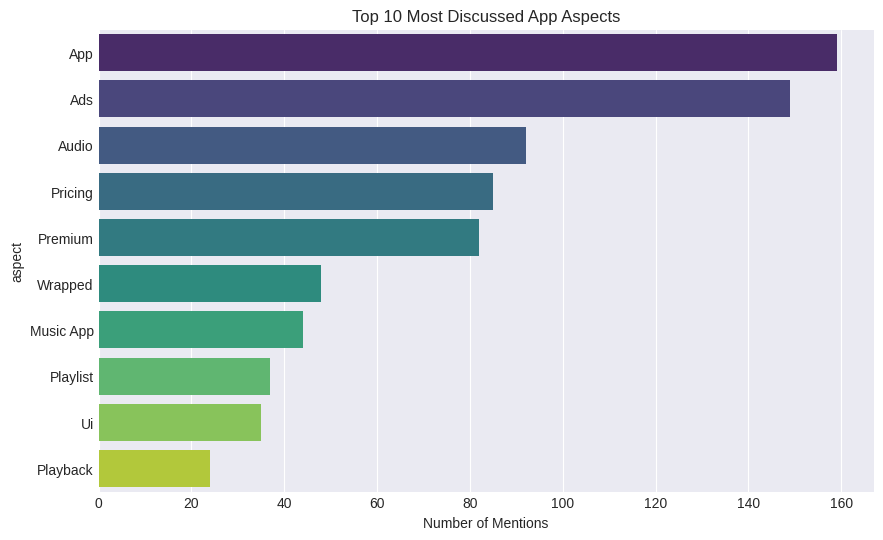

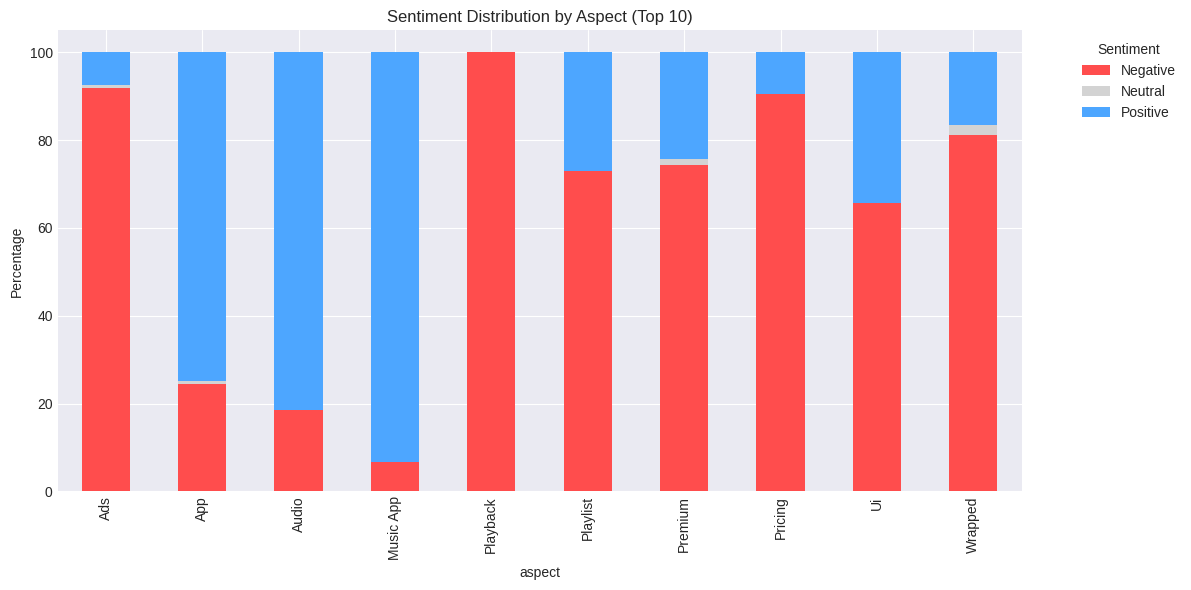

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Load the Results
try:
    results_df = pd.read_csv('llm_results_final.csv')
    print(f"Loaded {len(results_df)} rows of data.")
except FileNotFoundError:
    print("Error: Please upload 'llm_results_final.csv' first.")

# 2. Data Cleaning
results_df = results_df.dropna(subset=['aspect'])
results_df = results_df[results_df['aspect'].astype(str).str.lower() != 'none']

results_df['aspect'] = results_df['aspect'].astype(str).str.title()
results_df['sentiment'] = results_df['sentiment'].astype(str).str.title()

# 3. Visualization 1: Top 10 Most Discussed Aspects
plt.figure(figsize=(10, 6))
top_aspects = results_df['aspect'].value_counts().head(10)
sns.barplot(x=top_aspects.values, y=top_aspects.index, palette='viridis')
plt.title('Top 10 Most Discussed App Aspects')
plt.xlabel('Number of Mentions')
plt.show()

# 4. Visualization 2: Sentiment Stacked Bar Chart
top_aspect_names = top_aspects.index.tolist()
filtered_df = results_df[results_df['aspect'].isin(top_aspect_names)]

# (Aspect vs Sentiment)
sentiment_counts = pd.crosstab(filtered_df['aspect'], filtered_df['sentiment'], normalize='index') * 100

# Plot
desired_order = ['Negative', 'Neutral', 'Positive']
existing_cols = [c for c in desired_order if c in sentiment_counts.columns]
sentiment_counts = sentiment_counts[existing_cols]

color_map = {'Negative': '#ff4d4d', 'Neutral': '#d3d3d3', 'Positive': '#4da6ff'}
colors = [color_map[c] for c in existing_cols]

sentiment_counts.plot(kind='bar', stacked=True, figsize=(12, 6), color=colors)
plt.title('Sentiment Distribution by Aspect (Top 10)')
plt.ylabel('Percentage')
plt.legend(title='Sentiment', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

#EVALUATION

In [ ]:
import pandas as pd
from sklearn.metrics import accuracy_score

ground_truth_file = 'manual_labeling_task.csv'
prediction_file = 'llm_results_final.csv'

def normalize_text(text):
    """Simple helper to lower-case and strip text for fair comparison."""
    if pd.isna(text) or text == 'None':
        return []
    text = str(text).replace('[', '').replace(']', '').replace("'", "").replace('"', "")
    return [item.strip().lower() for item in text.split(',') if item.strip()]

# 1. Load Data
try:
    gt_df = pd.read_csv(ground_truth_file)
    pred_df = pd.read_csv(prediction_file)
except FileNotFoundError as e:
    print(f"Error: Could not find file. {e}")
    gt_df = pd.DataFrame() # Dummy to prevent crash

if not gt_df.empty:
    print(f"Loaded {len(gt_df)} Ground Truth reviews.")

    # 2. Prepare Counters
    tp_aspects = 0  # Correctly identified aspect
    fp_aspects = 0  # Model found an aspect that wasn't there
    fn_aspects = 0  # Model missed an aspect you found

    sentiment_matches = 0
    sentiment_total = 0

    # 3. Evaluation Loop
    # We only check the reviews that exist in your Ground Truth set
    for index, row in gt_df.iterrows():
        r_id = row['review_id']

        # Get Human Labels
        human_aspects_list = normalize_text(row['human_aspects'])
        # Create a dict for sentiment lookup: {'ui': 'negative', 'price': 'positive'}
        human_sentiments_list = normalize_text(row['human_sentiments'])

        # Safety check for list length mismatch in manual labeling
        if len(human_aspects_list) != len(human_sentiments_list):
            # If mismatch, slice to the shorter length to avoid crash
            min_len = min(len(human_aspects_list), len(human_sentiments_list))
            human_aspects_list = human_aspects_list[:min_len]
            human_sentiments_list = human_sentiments_list[:min_len]

        human_map = dict(zip(human_aspects_list, human_sentiments_list))

        # Get Model Labels for this ID
        model_rows = pred_df[pred_df['review_id'] == r_id]
        model_aspects_list = [str(x).lower().strip() for x in model_rows['aspect'].tolist() if str(x).lower() != 'none']
        model_sentiments_list = [str(x).lower().strip() for x in model_rows['sentiment'].tolist()]
        model_map = dict(zip(model_aspects_list, model_sentiments_list))

        # --- Task 1 Evaluation: Aspect Extraction (Set Comparison) ---
        human_set = set(human_aspects_list)
        model_set = set(model_aspects_list)

        # True Positives: Aspects in BOTH lists
        intersection = human_set.intersection(model_set)
        tp = len(intersection)

        # False Positives: Aspects in Model but NOT Human
        fp = len(model_set - human_set)

        # False Negatives: Aspects in Human but NOT Model
        fn = len(human_set - model_set)

        tp_aspects += tp
        fp_aspects += fp
        fn_aspects += fn

        for aspect in intersection:
            h_sent = human_map.get(aspect, 'neutral')
            m_sent = model_map.get(aspect, 'neutral')

            sentiment_total += 1
            if h_sent == m_sent:
                sentiment_matches += 1

    # 4. Calculate Metrics
    # Precision = TP / (TP + FP)  (How trustworthy is a "yes"?)
    precision = tp_aspects / (tp_aspects + fp_aspects) if (tp_aspects + fp_aspects) > 0 else 0

    # Recall = TP / (TP + FN)
    recall = tp_aspects / (tp_aspects + fn_aspects) if (tp_aspects + fn_aspects) > 0 else 0

    # F1 Score = Harmonic Mean
    f1_score = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0

    # Sentiment Accuracy
    sent_accuracy = sentiment_matches / sentiment_total if sentiment_total > 0 else 0

    # 5. Print Final Report
    print("="*50)
    print("FINAL PROJECT EVALUATION REPORT")
    print("="*50)
    print(f"Comparison Base: {len(gt_df)} Reviews")
    print("-" * 30)
    print("TASK 1: ASPECT EXTRACTION")
    print(f"True Positives (Agreed): {tp_aspects}")
    print(f"False Positives (Hallucinated): {fp_aspects}")
    print(f"False Negatives (Missed): {fn_aspects}")
    print("-" * 30)
    print(f"Precision: {precision:.4f}")
    print(f"Recall:    {recall:.4f}")
    print(f"F1-SCORE:  {f1_score:.4f}")
    print("-" * 30)
    print("TASK 2: SENTIMENT CLASSIFICATION")
    print(f"Evaluated on {sentiment_total} common aspects.")
    print(f"ACCURACY:  {sent_accuracy:.4f} ({sent_accuracy*100:.1f}%)")
    print("="*50)

Loaded 116 Ground Truth reviews.
FINAL PROJECT EVALUATION REPORT
Comparison Base: 116 Reviews
------------------------------
TASK 1: ASPECT EXTRACTION
True Positives (Agreed): 31
False Positives (Hallucinated): 144
False Negatives (Missed): 45
------------------------------
Precision: 0.1771
Recall:    0.4079
F1-SCORE:  0.2470
------------------------------
TASK 2: SENTIMENT CLASSIFICATION
Evaluated on 31 common aspects.
ACCURACY:  1.0000 (100.0%)


Semantic evaluation

In [ ]:
!pip install sentence-transformers

In [ ]:
import pandas as pd
from sentence_transformers import SentenceTransformer, util

ground_truth_file = 'manual_labeling_task.csv'
prediction_file = 'llm_results_final.csv'
SIMILARITY_THRESHOLD = 0.7

embedding_model = SentenceTransformer('all-MiniLM-L6-v2')

def normalize_text(text):
    if pd.isna(text) or str(text).lower() == 'none':
        return []
    text = str(text).replace('[', '').replace(']', '').replace("'", "").replace('"', "")
    return [item.strip() for item in text.split(',') if item.strip()]

gt_df = pd.read_csv(ground_truth_file)
pred_df = pd.read_csv(prediction_file)

print(f"--- INSPECTING MISMATCHES (Threshold: {SIMILARITY_THRESHOLD}) ---")
print(f"{'Review ID':<10} | {'Your Labels':<30} | {'AI Labels':<30} | {'Best Match Score'}")
print("-" * 90)

mismatch_count = 0

for index, row in gt_df.iterrows():
    if mismatch_count >= 20: break # Stop after printing 20 examples
    r_id = row['review_id']
    human_aspects = normalize_text(row['human_aspects'])

    # Get model tags
    model_rows = pred_df[pred_df['review_id'] == r_id]
    model_aspects = [str(x).strip() for x in model_rows['aspect'].tolist() if str(x).lower() != 'none']

    # Skip if both empty (perfect match)
    if not human_aspects and not model_aspects:
        continue

    if set(human_aspects) == set(model_aspects):
        continue

    # Semantic Check
    human_embeddings = embedding_model.encode(human_aspects, convert_to_tensor=True)
    model_embeddings = embedding_model.encode(model_aspects, convert_to_tensor=True)

    if len(human_aspects) == 0 or len(model_aspects) == 0:
        print(f"{str(r_id)[:8]}.. | {str(human_aspects):<30} | {str(model_aspects):<30} | 0.0 (Empty side)")
        mismatch_count += 1
        continue

    cosine_scores = util.cos_sim(human_embeddings, model_embeddings)

    best_match_scores = cosine_scores.max(dim=1).values
    lowest_best_score = best_match_scores.min().item()

    if lowest_best_score < SIMILARITY_THRESHOLD:
        print(f"{str(r_id)[:8]}.. | {str(human_aspects):<30} | {str(model_aspects):<30} | {lowest_best_score:.4f}")
        mismatch_count += 1

--- INSPECTING MISMATCHES (Threshold: 0.7) ---
Review ID  | Your Labels                    | AI Labels                      | Best Match Score
------------------------------------------------------------------------------------------
253700e3.. | ['Audio']                      | ['Lyrics']                     | 0.3430
a50463df.. | []                             | ['nan']                        | 0.0 (Empty side)
2c183304.. | ['Pricing']                    | ['Ads']                        | 0.4277
86d080a6.. | []                             | ['nan']                        | 0.0 (Empty side)
c09a65aa.. | ['Features']                   | ['Wrapped']                    | 0.1870
d8a06439.. | ['Audio']                      | ['Playlist', 'Ads']            | 0.4619
c0bb03c0.. | ['Pricing']                    | ['Premium', 'Playback']        | 0.5689
c0bb03c0.. | ['Features']                   | ['Premium', 'Playback']        | 0.2584
ad8473b4.. | ['Features']                   | ['App', 'Pla

In [ ]:
import pandas as pd
from sentence_transformers import SentenceTransformer, util

# --- CONFIGURATION ---
ground_truth_file = 'manual_labeling_task.csv'
prediction_file = 'llm_results_final.csv'
SIMILARITY_THRESHOLD = 0.55
PRINT_MISMATCHES = True
print("Loading semantic model...")
embedding_model = SentenceTransformer('all-MiniLM-L6-v2')

def normalize_text(text):
    """
    Robust cleaning:
    1. Lowers case and strips whitespace.
    2. Removes Python list artifacts ([], '', "").
    3. STRICTLY removes 'nan', 'none', 'null' strings.
    """
    text = str(text).lower().strip()
    if text in ['nan', 'none', '', 'null']:
        return []

    # Remove artifacts
    text = text.replace('[', '').replace(']', '').replace("'", "").replace('"', "")

    # Split by comma
    items = [item.strip() for item in text.split(',') if item.strip()]

    # Filter out specific bad words
    clean_items = [x for x in items if x not in ['nan', 'none', 'null']]
    return clean_items

# 1. Load Data
try:
    gt_df = pd.read_csv(ground_truth_file)
    pred_df = pd.read_csv(prediction_file)
except Exception as e:
    print(f"Error loading files: {e}")
    gt_df = pd.DataFrame()

if not gt_df.empty:
    tp_for_recall = 0
    tp_for_precision = 0
    total_human_tags = 0
    total_model_tags = 0

    print(f"\nEvaluating {len(gt_df)} reviews (Threshold: {SIMILARITY_THRESHOLD})...")

    if PRINT_MISMATCHES:
        print("\n" + "="*100)
        print(f"{'Review ID':<10} | {'Your Labels':<30} | {'AI Labels':<30} | {'Score'}")
        print("="*100)

    mismatch_count = 0

    for index, row in gt_df.iterrows():
        r_id = row['review_id']
        human_aspects = normalize_text(row['human_aspects'])

        # Get model predictions for this ID
        model_rows = pred_df[pred_df['review_id'] == r_id]

        # Flatten list of aspects from model rows
        raw_model_aspects = model_rows['aspect'].tolist()
        model_aspects = []
        for x in raw_model_aspects:
            model_aspects.extend(normalize_text(x))

        # Deduplicate
        model_aspects = list(set(model_aspects))

        total_human_tags += len(human_aspects)
        total_model_tags += len(model_aspects)

        if len(human_aspects) == 0 or len(model_aspects) == 0:
            # Handle empty cases for printing
            if PRINT_MISMATCHES and mismatch_count < 30: # Limit print to first 30
                if human_aspects != model_aspects:
                    print(f"{str(r_id)[:8]}.. | {str(human_aspects):<30} | {str(model_aspects):<30} | 0.0 (Empty)")
                    mismatch_count += 1
            continue

        # Semantic Encoding
        human_embeddings = embedding_model.encode(human_aspects, convert_to_tensor=True)
        model_embeddings = embedding_model.encode(model_aspects, convert_to_tensor=True)

        cosine_scores = util.cos_sim(human_embeddings, model_embeddings)

        # Update Metrics
        tp_for_recall += (cosine_scores.max(dim=1).values > SIMILARITY_THRESHOLD).sum().item()
        tp_for_precision += (cosine_scores.max(dim=0).values > SIMILARITY_THRESHOLD).sum().item()

        if PRINT_MISMATCHES and mismatch_count < 30:
            min_score = cosine_scores.max(dim=1).values.min().item()

            if min_score < SIMILARITY_THRESHOLD:
                print(f"{str(r_id)[:8]}.. | {str(human_aspects):<30} | {str(model_aspects):<30} | {min_score:.4f}")
                mismatch_count += 1

    # Final Math
    precision = tp_for_precision / total_model_tags if total_model_tags > 0 else 0
    recall = tp_for_recall / total_human_tags if total_human_tags > 0 else 0
    f1_score = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0

    print("\n" + "="*50)
    print(f"SEMANTIC EVALUATION REPORT (Fixed 'nan' bug)")
    print("="*50)
    print(f"Precision: {precision:.4f}")
    print(f"Recall:    {recall:.4f}")
    print(f"F1-SCORE:  {f1_score:.4f}")
    print("="*50)

Loading semantic model...

Evaluating 116 reviews (Threshold: 0.55)...

Review ID  | Your Labels                    | AI Labels                      | Score
253700e3.. | ['audio']                      | ['lyrics']                     | 0.3430
2c183304.. | ['pricing']                    | ['ads']                        | 0.4277
c09a65aa.. | ['features']                   | ['wrapped']                    | 0.1870
d8a06439.. | ['audio']                      | ['playlist', 'ads']            | 0.4619
c0bb03c0.. | ['features']                   | ['playback', 'premium']        | 0.2584
ad8473b4.. | ['features']                   | ['playlist', 'skip', 'shuffle', 'app'] | 0.3952
ad8473b4.. | ['audio']                      | ['playlist', 'skip', 'shuffle', 'app'] | 0.4619
71dbdcb9.. | ['features']                   | ['updates']                    | 0.3945
91032220.. | ['features']                   | ['music library', 'app stability'] | 0.2388
91032220.. | ['audio']                      | ['m

Evaluation with LLM as a Judge

In [ ]:
import pandas as pd
import json
import time
import os
from tqdm import tqdm
import google.generativeai as genai
from google.api_core.exceptions import ResourceExhausted


JUDGE_MODEL_NAME = 'gemini-2.5-flash'

ground_truth_file = 'manual_labeling_task.csv'
prediction_file = 'llm_results_final.csv'
# ---------------------

# Initialize Gemini
model = genai.GenerativeModel(
    model_name=JUDGE_MODEL_NAME,
    generation_config={"response_mime_type": "application/json"}
)

def safe_api_call(func, *args, **kwargs):
    """Robust API caller that handles quotas."""
    max_retries = 5
    wait_time = 30
    for attempt in range(max_retries):
        try:
            return func(*args, **kwargs)
        except ResourceExhausted:
            print(f" [!] Quota hit. Sleeping {wait_time}s...", end="", flush=True)
            time.sleep(wait_time)
            wait_time += 10
        except Exception as e:
            print(f" [!] Error: {e}. Retrying...", end="", flush=True)
            time.sleep(5)
    return None

def normalize_text(text):
    """Clean text to list, removing 'nan'."""
    text = str(text).lower().strip()
    if text in ['nan', 'none', '', 'null']: return []
    text = text.replace('[', '').replace(']', '').replace("'", "").replace('"', "")
    items = [item.strip() for item in text.split(',') if item.strip()]
    return [x for x in items if x not in ['nan', 'none', 'null']]

# 1. Load Data
print("Loading data...")
try:
    gt_df = pd.read_csv(ground_truth_file)
    pred_df = pd.read_csv(prediction_file)
except:
    print("Error loading CSV files.")
    gt_df = pd.DataFrame()

# 2. Evaluation Loop
total_tp = 0
total_fp = 0
total_fn = 0

if not gt_df.empty:
    print(f"Starting LLM-as-a-Judge Evaluation on {len(gt_df)} reviews...")
    print(f"Judge Model: {JUDGE_MODEL_NAME}\n")

    # We use tqdm for a progress bar
    for index, row in tqdm(gt_df.iterrows(), total=len(gt_df)):
        r_id = row['review_id']
        review_text = str(row['review'])

        # Get Human Labels
        human_aspects = normalize_text(row['human_aspects'])

        # Get AI Prediction Labels
        model_rows = pred_df[pred_df['review_id'] == r_id]
        ai_aspects = []
        for x in model_rows['aspect'].tolist():
            ai_aspects.extend(normalize_text(x))
        ai_aspects = list(set(ai_aspects))

        # OPTIMIZATION: If exact match, skip API call to save time/money
        if set(human_aspects) == set(ai_aspects):
            total_tp += len(human_aspects)
            continue

        # JUDGE PROMPT
        # We ask the LLM to do the math for us based on semantic logic
        prompt = f"""
        You are an expert evaluator for an Aspect-Based Sentiment Analysis system.

        Review Text: "{review_text}"

        Human Ground Truth Labels: {json.dumps(human_aspects)}
        AI Predicted Labels: {json.dumps(ai_aspects)}

        Task: Compare the AI labels to the Human labels. Count True Positives, False Positives, and False Negatives.

        Rules:
        1. Be lenient with synonyms (e.g. Human "Audio" matches AI "Music").
        2. Be lenient with granularity (e.g. Human "Features" matches AI "Wrapped" if Wrapped is a feature mentioned in the text).
        3. False Positive (FP): AI found something completely unrelated or wrong.
        4. False Negative (FN): AI missed a concept the Human found.
        5. True Positive (TP): AI correctly identified a concept the Human found.

        Output JSON ONLY: {{"tp": <int>, "fp": <int>, "fn": <int>}}
        """

        response = safe_api_call(model.generate_content, prompt)

        time.sleep(2)

        if response:
            try:
                scores = json.loads(response.text)
                total_tp += scores.get('tp', 0)
                total_fp += scores.get('fp', 0)
                total_fn += scores.get('fn', 0)
            except:
                print(f"Failed to parse JSON for ID {r_id}")

    precision = total_tp / (total_tp + total_fp) if (total_tp + total_fp) > 0 else 0
    recall = total_tp / (total_tp + total_fn) if (total_tp + total_fn) > 0 else 0
    f1_score = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0

    print("\n" + "="*50)
    print("NUCLEAR EVALUATION REPORT (LLM Judge)")
    print("="*50)
    print(f"True Positives:  {total_tp}")
    print(f"False Positives: {total_fp}")
    print(f"False Negatives: {total_fn}")
    print("-" * 30)
    print(f"Precision: {precision:.4f}")
    print(f"Recall:    {recall:.4f}")
    print(f"F1-SCORE:  {f1_score:.4f}")
    print("="*50)

Loading data...
Starting LLM-as-a-Judge Evaluation on 116 reviews...
Judge Model: gemini-2.5-flash



100%|██████████| 116/116 [11:24<00:00,  5.90s/it]


NUCLEAR EVALUATION REPORT (LLM Judge)
True Positives:  73
False Positives: 69
False Negatives: 14
------------------------------
Precision: 0.5141
Recall:    0.8391
F1-SCORE:  0.6376


##VADER

This code block establishes a baseline for performance comparison by implementing a traditional lexicon-based sentiment analysis using the VADER library. It iterates through the manually labeled ground truth dataset, assigning a single sentiment label (Positive, Negative, or Neutral) to the entire text of each review based on its compound score. This document-level sentiment is then compared against each fine-grained, aspect-specific sentiment labeled by the human annotator to calculate an overall accuracy score. The final output includes a classification report that highlights the limitations of using sentence-level analysis for aspect-based tasks, particularly its inability to distinguish conflicting sentiments within a single review.

In [ ]:
!pip install vaderSentiment

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 126.0/126.0 kB 3.8 MB/s eta 0:00:00


In [ ]:
import pandas as pd
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from sklearn.metrics import accuracy_score, classification_report

ground_truth_file = 'manual_labeling_task.csv'

# Initialize VADER
analyzer = SentimentIntensityAnalyzer()

def get_vader_sentiment(text):
    """
    Returns 'Positive', 'Negative', or 'Neutral' based on compound score.
    Thresholds:
    - Positive: >= 0.05
    - Negative: <= -0.05
    - Neutral:  Between -0.05 and 0.05
    """
    if pd.isna(text): return "Neutral"

    scores = analyzer.polarity_scores(str(text))
    compound = scores['compound']

    if compound >= 0.05:
        return "Positive"
    elif compound <= -0.05:
        return "Negative"
    else:
        return "Neutral"

def normalize_text(text):
    """Clean text to list."""
    text = str(text).lower().strip()
    if text in ['nan', 'none', '', 'null']: return []
    text = text.replace('[', '').replace(']', '').replace("'", "").replace('"', "")
    items = [item.strip() for item in text.split(',') if item.strip()]
    return [x for x in items if x not in ['nan', 'none', 'null']]

# 1. Load Ground Truth
try:
    df = pd.read_csv(ground_truth_file)
    print(f"✓ Loaded {len(df)} Ground Truth reviews.")
except Exception as e:
    print(f"Error loading file: {e}")
    df = pd.DataFrame()

# 2. Run Baseline Comparison
y_true = []
y_pred_vader = []

if not df.empty:
    print("Running VADER Baseline...")

    for index, row in df.iterrows():
        review_text = row['review']

        # 1. Get VADER's opinion on the WHOLE review
        vader_label = get_vader_sentiment(review_text)

        # 2. Get Human Labels for aspects
        human_sentiments = normalize_text(row['human_sentiments'])

        for h_sentiment in human_sentiments:
            # Normalize to Title Case for comparison
            h_clean = h_sentiment.title()
            v_clean = vader_label.title()

            if h_clean in ['Pos', 'Good']: h_clean = 'Positive'
            if h_clean in ['Neg', 'Bad']: h_clean = 'Negative'
            if h_clean in ['Neu', 'Mixed']: h_clean = 'Neutral'

            y_true.append(h_clean)
            y_pred_vader.append(v_clean)

    accuracy = accuracy_score(y_true, y_pred_vader)
    print("\n" + "="*50)
    print("BASELINE REPORT: VADER (Lexicon)")
    print("="*50)
    print(f"ACCURACY: {accuracy:.4f} ({accuracy*100:.1f}%)")
    print("-" * 50)
    print("Detailed Report:")
    print(classification_report(y_true, y_pred_vader, zero_division=0))
    print("="*50)

✓ Loaded 116 Ground Truth reviews.
Running VADER Baseline...

BASELINE REPORT: VADER (Lexicon)
ACCURACY: 0.4342 (43.4%)
--------------------------------------------------
Detailed Report:
              precision    recall  f1-score   support

    Negative       1.00      0.26      0.41        58
     Neutral       0.00      0.00      0.00         0
    Positive       0.35      1.00      0.52        18

    accuracy                           0.43        76
   macro avg       0.45      0.42      0.31        76
weighted avg       0.85      0.43      0.44        76

